<a href="https://colab.research.google.com/github/ahsanrazi/LangChain/blob/main/Blog_Generation_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -qU langchain_google_genai
!pip install -qU langgraph
!pip install -qU langchain_core
!pip install -qU langchain-community
!pip install -qU duckduckgo-search

In [7]:
import textwrap
from IPython.display import Markdown

def to_markdown(text) -> Markdown:
    text: str = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [8]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY').strip()

In [24]:
from typing import List, Dict
from typing_extensions import TypedDict

# Define State
class BlogState(TypedDict):
    topic: str
    search_queries: List[str]
    blog_topics: List[str]
    final_topic: str
    blog_content: str
    image_formated_blog: str
    prompts: Dict[str, str]

In [25]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", api_key = gemini_api_key)

In [26]:
from langchain_core.prompts import PromptTemplate

queries_prompt_template = PromptTemplate.from_template("""
You are an expert in generating effective search queries to discover the latest trends, news, laws, regulations, and recent developments in {year} related to a Topic in United Kingdom.
Based on the Topic provided, create a comprehensive and highly relevant search queries that can be used in search engines to find up-to-date information.

# The queries should cover:
- Latest trends and emerging topics
- Recent news and noteworthy events
- New or updated laws and regulations
- Market insights and innovations
- Expert opinions and industry reports

# Generate at least 5 specific, diverse, and concise search queries that capture different aspects of the Topic.
# Use variations in phrasing to ensure comprehensive search results.
# Make sure the queries are unique So that we get diverse search results.
# Don't include any irrelevant information in the queries like Markdown, Newlines etc. Only give the search queries.

Topic = {topic}
""")

In [27]:
# Generate Queries
from datetime import date
current_year = date.today().strftime("%Y")

def queries(state: BlogState):
  topic = state["topic"][0].content
  prompt = queries_prompt_template.invoke({"topic": topic, "year": current_year})
  response = llm.invoke(prompt)
  content = response.content
  response_list = [item.strip('"') for item in content.split('\n')]
  print(response_list)
  return {"search_queries": response_list}

In [28]:
from langchain_community.tools import DuckDuckGoSearchResults
import time

def search_topics(queries):
  titles = []
  search = DuckDuckGoSearchResults(output_format="list")
  for query in queries:
    time.sleep(5)
    response = search.invoke(query)
    for r in response:
      titles.append(r['title'])

  return titles

In [29]:
# DuckDuckGo Search Queries
from langchain_community.tools import DuckDuckGoSearchRun

def blog_topic(state: BlogState):
  queries = state["search_queries"]
  topics = search_topics(queries)
  print(topics)
  return {"blog_topics": topics}

In [30]:
from langchain_core.prompts import PromptTemplate

final_topic_prompt_template = PromptTemplate.from_template("""
## Role:
You are an **expert content strategist** tasked with selecting the most **engaging and informative** blog topic from the provided list. Your objective is to **maximize audience interest, deliver valuable insights, and encourage readers to click and read the full article**.

## Selection Criteria:
The chosen topic should meet the following standards:
- **High Relevance**: Aligns with current events, trends, or regulations.
- **Clear Value Proposition**: Provides useful information or solutions.
- **Addresses Common Questions**: Solves widespread confusion or concerns.
- **Emotional or Practical Appeal**: Resonates with the target audience, sparking curiosity or urgency.

## Instructions:
1. **Analyze** the provided list of blog topics.
2. **Select** the topic that best meets the selection criteria.
3. **Enhance** the chosen title to be more engaging, clickable, and reader-friendly.
4. **Keep the final title concise, compelling, and optimized for high engagement.**

## Example Blog Titles:
- Is It Time To Replace Your Boiler?
- Cold Radiators? Let’s Look at the Reasons
- Modern Oil Boilers - A Reliable Heating Solution for Homes Across Devon
- Why Invest in a New Central Heating System
- When Is the Right Time to Replace Your Boiler?
- Common Boiler Faults That Are Repaired by Gas Engineers
- Air Source Heat Pumps vs. Traditional Boilers: Which Is Right for You?
- What Are Smart Thermostats and Are They Worth Installing?
- Telltale Signs It’s Time to Replace Your Boiler
- Is It Worth Investing in a New Central Heating System?
- Common Boiler Faults That Are Repaired by Gas Engineers
- Are Smart Thermostats Worth Installing for Gas Central Heating?

## Output Format:
- **Only provide the final enhanced blog title.**
- **Do not include explanations, reasoning, additional text or any pucntuation mark in the blog title.**

**List = {list}**
""")

In [31]:
# Finalize the topic

def final_topic(state: BlogState):
  topics = state["blog_topics"]
  prompt = final_topic_prompt_template.invoke({"list": topics})
  response = llm.invoke(prompt)
  content = response.content
  print(content)

  return {"final_topic": content}

In [32]:
def blog_agent(state: BlogState):
  from langgraph.graph import MessagesState
  from langchain_community.tools import DuckDuckGoSearchRun
  from langchain_google_genai import ChatGoogleGenerativeAI
  from langchain_core.messages import HumanMessage, SystemMessage
  topic = state["final_topic"]
  # tool
  def duckduckgo_search(query: str) -> str:
    """
    Performs a search on DuckDuckGo using the provided query.
    Args:
        query (str): The search query to be executed.
    Returns:
        str: The result of the search query.
    """
    search = DuckDuckGoSearchRun()
    result = search.invoke(query)
    return result

  tool = [duckduckgo_search]
  llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", api_key =  gemini_api_key)
  llm_with_tools = llm.bind_tools(tool)



# System message
  sys_msg = SystemMessage(content="""
Task: You are an expert Blog post generator. Generate a blog post on the topic given to you by using the examples below as a guide.


Examples:

Example 1:
# Is It Time To Replace Your Boiler?

A boiler is the heart of your home’s heating system, working tirelessly behind the scenes to provide hot water and warmth. Often taken for granted, it operates quietly and efficiently—until something goes wrong. Like any appliance, boilers have a limited lifespan and will eventually show signs of wear and tear. Neglecting these warning signs can lead to higher energy bills, costly repairs, and even unexpected breakdowns, leaving you without heat or hot water when you need it most.

Recognising when to replace your boiler is crucial to maintaining a safe, efficient, and comfortable home. By upgrading to a modern, energy-efficient model, you can enjoy lower energy costs, better performance, and peace of mind. In this guide, we’ll highlight the key indicators that it might be time to retire your old boiler and invest in a replacement.

## 1. Your Boiler is Over 10-15 Years Old

The typical lifespan of a boiler is around 10-15 years, depending on the make, model, and maintenance history. Older boilers are often less efficient, costing more to run and repair. Even if your boiler appears to be functioning, upgrading to a modern, energy-efficient model is worth considering. Newer boilers are typically A-rated for efficiency and can save you a significant amount on your energy bills over time.

## 2. Frequent Breakdowns and Repairs

Regular breakdowns are a clear sign that your boiler is nearing the end of its life. While occasional repairs are to be expected, frequent callouts can quickly become expensive. If you find yourself repeatedly fixing the same issues or spending more than half the cost of a new boiler on repairs, it’s time to invest in a replacement.

## 3. Increasing Energy Bills

If your energy bills are creeping up despite consistent usage, your boiler might be losing efficiency. As boilers age, their components wear out, making them work harder to produce the same amount of heat. This inefficiency not only affects your wallet but also increases your carbon footprint.

## 4. Strange Noises

While no boiler is entirely silent, unusual sounds like banging, whistling, or gurgling could indicate a serious problem. These noises may be caused by internal components wearing out, sediment build-up, or even air in the system. Although some of these issues can be repaired, persistent noises are often a sign that your boiler is on its last legs.

## 5. Uneven Heating in Your Home

If some rooms in your house feel colder than others, it might be a sign that your boiler is struggling to distribute heat effectively. Poor performance can be caused by wear and tear, blockages, or an inability to meet your home’s heating demands. A new boiler can resolve these issues, ensuring consistent warmth throughout your home.

## 6. Yellow Flame or Pilot Light Issues

A healthy boiler flame should burn bright blue. If you notice a yellow or orange flame, it could indicate incomplete combustion, which may lead to carbon monoxide production. Carbon monoxide is a highly dangerous gas that’s odourless and colourless. If your boiler’s pilot light frequently goes out or the flame changes colour, seek professional help immediately and consider a replacement.

## 7. Leaks and Corrosion

Water leaks around your boiler or visible signs of corrosion are clear indicators of serious issues. Leaks can damage other components, lead to inefficiency, and even cause structural damage to your home. While small leaks might be repairable, widespread corrosion often means your boiler needs to be replaced.

## 8. Outdated Technology

Older boilers lack the modern technology found in newer models, such as smart controls, weather compensation, and energy monitoring. These features not only improve convenience but also help optimise efficiency and reduce running costs. If your boiler doesn’t support these advancements, upgrading could be a wise decision.

## 9. Failing to Meet Your Heating and Hot Water Needs

If your boiler takes longer to heat up, struggles to provide enough hot water, or fails to keep your home warm, it’s time to consider a replacement. Boilers that can no longer cope with your household’s demands are not only inconvenient but also inefficient.

## Key Signs You Need a New Boiler

Replacing your boiler might seem like a significant investment, but it can save you money and provide peace of mind in the long run. An energy-efficient boiler reduces your heating costs, lowers your carbon footprint, and ensures reliable performance. If you recognise any of the signs above, it’s worth consulting a professional heating engineer to discuss your options. Don’t wait for a complete breakdown—a proactive approach can prevent inconvenience and additional costs during the colder months. The team at South Coast Plumbing and Heating will give you an honest opinion about replacing your boiler - contact us today.


Example 2:
# When Is the Right Time to Replace Your Boiler?

Your boiler is one of the most important appliances in your home, providing hot water and central heating throughout the year. However, like any other household system, boilers don’t last forever. Knowing when to replace your boiler can save you from unexpected breakdowns, costly repairs, and inefficient energy use. In this guide, we’ll explore the key signs that indicate it might be time for an upgrade.

## How Long Does a Boiler Last?

Most boilers have a lifespan of around 10 to 15 years, depending on the make, model, and how well they’ve been maintained. If your boiler is reaching or exceeding this age, it’s worth considering a replacement, even if it appears to be functioning normally. Older boilers tend to be less efficient, leading to higher energy bills, and they are more prone to faults.

Regular servicing can help extend the life of your boiler, but eventually, wear and tear will take its toll. If your boiler is over a decade old, it may not comply with modern energy efficiency standards, meaning you could be spending more on heating than necessary.

## Signs You Need a New Boiler

If you’re unsure whether your boiler needs replacing, look out for these warning signs:

- **Frequent Breakdowns**: If your boiler is constantly needing repairs, replacing it could be more cost-effective in the long run.
- **Rising Energy Bills**: An older, inefficient boiler will use more fuel to heat your home, increasing your energy costs.
- **Strange Noises**: Banging, whistling, or gurgling sounds could indicate serious internal problems.
- **Uneven Heating**: If some rooms are colder than others, your boiler may be struggling to distribute heat effectively.
- **Leaks or Corrosion**: Visible signs of damage, such as water leaks or rusting components, suggest your boiler is deteriorating.
- **Difficulties Finding Spare Parts**: If your boiler model has been discontinued, sourcing replacement parts can become expensive and difficult.
- **Your Boiler Has a Low Efficiency Rating**: Older boilers typically have lower efficiency ratings (G-rated, for example), meaning they waste more energy compared to modern A-rated models.

## Benefits of Replacing Your Boiler

Investing in a new boiler comes with several advantages. Firstly, modern boilers are far more energy-efficient, which can significantly lower your heating bills. New models are designed to work with smart thermostats, allowing you to control your heating more effectively and reduce unnecessary energy consumption.

A new boiler also improves the overall comfort of your home. You’ll enjoy a more consistent and reliable heating system, with fewer disruptions and repairs. Additionally, newer boilers are quieter, take up less space, and are better for the environment due to lower carbon emissions.

## Choosing the Right Boiler for Your Home

If you’ve decided it’s time to replace your boiler, choosing the right model is essential. Factors to consider include the size of your home, the number of bathrooms, and your household’s hot water demands. Combi boilers are ideal for smaller homes with one bathroom, while system or regular boilers are better suited for larger properties with higher water usage.

It’s always best to consult a professional heating engineer before making a decision. At Cheltenham Heating Solutions, we can assess your needs and recommend the most efficient and cost-effective option for your home.

## Final Thoughts

Replacing your boiler is a big investment, but it’s one that can bring significant benefits in terms of efficiency, comfort, and cost savings. If your boiler is old, unreliable, or struggling to keep up with your heating demands, now might be the right time to upgrade. Speak to our qualified heating experts to explore your options and ensure you get the best system for your requirements.


Context:
- The blog post should be informative and engaging.
- Always Use the attached tool duckduckgo_search to get the latest information about the topic.

Constraints:
- The blog post should be between 700 to 800 words.
- Use clear headings without punctuation marks, similar to the example blogs.
- Dont include any punctuation mark in the headings.
- Maintain a professional tone throughout the blog.
- Keep the Blog Title same as topic don't change it.

Output Format:
- A well-structured blog post in the Markdown format.
- Well-structured sections with clear subheadings.

""")

# Node
  def assistant(state: MessagesState) -> MessagesState:
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

  from langgraph.graph import START, StateGraph
  from langgraph.prebuilt import tools_condition
  from langgraph.prebuilt import ToolNode
  from langgraph.graph.state import CompiledStateGraph

  builder: StateGraph = StateGraph(MessagesState)

  builder.add_node("assistant", assistant)
  builder.add_node("tools", ToolNode(tool))


  builder.add_edge(START, "assistant")
  builder.add_conditional_edges(
    "assistant",
    tools_condition,
  )
  builder.add_edge("tools", "assistant")
  react_graph: CompiledStateGraph = builder.compile()

  message = [HumanMessage(content=f"Search this query: {topic}")]
  messages = react_graph.invoke({"messages": message})
  print(messages['messages'][3].content)
  return {"blog_content": messages['messages'][3].content}

In [50]:
from langchain_core.prompts import PromptTemplate

image_blog_prompt_template = PromptTemplate.from_template("""
Task: You are an expert in enhancing blog posts by strategically placing images to improve reader engagement and visual appeal. Your task is to read and understand the provided Blog content and determine the optimal positions for three images within the text.

Instructions:
- Carefully read the Blog content to understand its structure, flow, and key points.
- Place the first image directly below the Blog title heading.
- Identify two additional suitable locations within the Blog content where images can enhance the narrative or emphasize important information.
- Insert the marker **### (Image_1 Here) (Image_2 Here) (Image_3 Here)** dynamically at the three chosen locations in the Blog content.

Constraints:
- Don't change the Blog content. Keep it as it is.
- There must be three pictures in the Blog not more than three.
- One picture must be below the Blog title heading.
- Don't incude any extra information.

Blog = {blog}

""")

In [51]:
def image_formatted_blog(state: BlogState):
  blog = state["blog_content"]
  prompt = image_blog_prompt_template.invoke({"blog": blog})
  response = llm.invoke(prompt)
  content = response.content
  print(content)
  return {"image_formated_blog": content}

In [52]:
from langchain_core.prompts import PromptTemplate

image_prompt_template = PromptTemplate.from_template("""
Task: You are an expert in enhancing blog posts by strategically generating images generation prompt to improve reader engagement and visual appeal. Your task is to read and understand the provided Blog content and generate image generation prompt for the model according to the above and below context of the Blog.

Instructions:
- Carefully read the Blog content to understand its structure, flow, and key points.
- Generate image generation prompt for the Model according to the above and below context of the Blog.
- Generate image prompt at the the marker **(Image_1 Here) (Image_2 Here) (Image_3 Here)** in the Blog.

Constraints:
- Don't change the Blog content. Keep it as it is.
- The images prompts must align with the Blog content and specific portion in the Blog.
- Don't incude any extra information.

Output format:
- Give the prompts in the dictionary format like image_1 key and prompt value and so on.

Blog = {blog}

""")

In [53]:
def image_prompts(state: BlogState):
  blog = state["image_formated_blog"]
  prompt = image_prompt_template.invoke({"blog": blog})
  response = llm.invoke(prompt)
  content = response.content
  print(content)
  return {"prompts": content}

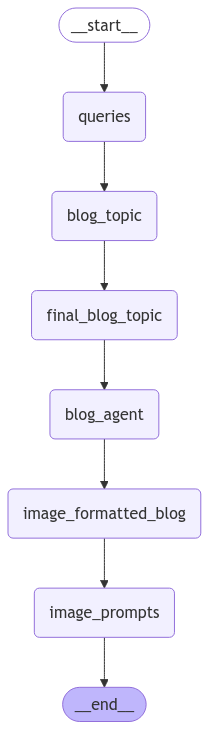

In [54]:
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Graph
builder = StateGraph(BlogState)

# Define nodes: these do the work
builder.add_node("queries", queries)
builder.add_node("blog_topic", blog_topic)
builder.add_node("final_blog_topic", final_topic)
builder.add_node("blog_agent", blog_agent)
builder.add_node("image_formatted_blog", image_formatted_blog)
builder.add_node("image_prompts", image_prompts)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "queries")
builder.add_edge("queries", "blog_topic")
builder.add_edge("blog_topic", "final_blog_topic")
builder.add_edge("final_blog_topic", "blog_agent")
builder.add_edge("blog_agent", "image_formatted_blog")
builder.add_edge("image_formatted_blog", "image_prompts")
builder.add_edge("image_prompts", END)

graph= builder.compile()

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [55]:
from langchain_core.messages import HumanMessage

topic = [HumanMessage(content="Gas Boilers")]
result = graph.invoke({"topic": topic})

['Gas boiler ban UK 2025', 'UK gas boiler replacement regulations 2025', 'Heat pump incentives UK 2025 gas boiler alternative', 'Future of gas boilers UK 2025 government policy', 'Gas boiler market trends UK 2025']
['What is the gas boiler ban and will it take affect in 2027 ...', 'Gas Boiler Ban: Will They Be Phased Out in 2025 or 2035? - Boiler Guide', 'UK scraps plan to ban gas boilers by 2035: Can the ... - Euronews', 'UK Gas Boiler Ban - Gas Boilers Phased Out 2025-2035 - Heatable', 'UK Gas Boiler Ban - In Effect from 2025 or 2035? - GreenMatch.co.uk', "What Will Replace Gas Boilers in 2025? (Don't Worry, You Can ... - Heatable", 'Gas Boiler Ban UK - Should You Replace Yours By 2025? - Energy Guide', 'Gas Boiler Ban: Will They Be Phased Out in 2025 or 2035? - Boiler Guide', 'Plans, policies, and incentives: What to expect from the heat pump ...', 'Boiler Upgrade Scheme (BUS) 2025: Eligibility, Grants & How to Apply', 'Heat Pump UK Government Grants 2025 | How to Apply - The Eco Ex

In [56]:
result

{'topic': [HumanMessage(content='Gas Boilers', additional_kwargs={}, response_metadata={})],
 'search_queries': ['Gas boiler ban UK 2025',
  'UK gas boiler replacement regulations 2025',
  'Heat pump incentives UK 2025 gas boiler alternative',
  'Future of gas boilers UK 2025 government policy',
  'Gas boiler market trends UK 2025'],
 'blog_topics': ['What is the gas boiler ban and will it take affect in 2027 ...',
  'Gas Boiler Ban: Will They Be Phased Out in 2025 or 2035? - Boiler Guide',
  'UK scraps plan to ban gas boilers by 2035: Can the ... - Euronews',
  'UK Gas Boiler Ban - Gas Boilers Phased Out 2025-2035 - Heatable',
  'UK Gas Boiler Ban - In Effect from 2025 or 2035? - GreenMatch.co.uk',
  "What Will Replace Gas Boilers in 2025? (Don't Worry, You Can ... - Heatable",
  'Gas Boiler Ban UK - Should You Replace Yours By 2025? - Energy Guide',
  'Gas Boiler Ban: Will They Be Phased Out in 2025 or 2035? - Boiler Guide',
  'Plans, policies, and incentives: What to expect from the

In [57]:
to_markdown(result['blog_content'])

> # Gas Boiler Ban 2025 or 2035 What You Need to Know
> 
> The future of home heating is a topic of much discussion, especially when it comes to gas boilers. With increasing focus on reducing carbon emissions and promoting sustainable energy solutions, many homeowners are wondering about the future of their heating systems. Concerns about potential bans on gas boilers have been circulating, and it's essential to stay informed to make the best decisions for your home and budget.
> 
> ## Understanding the Proposed Ban
> 
> Originally, there were discussions around phasing out gas boilers as early as 2025 for new builds, with a more comprehensive ban expected by 2035. These proposals were part of broader initiatives like the Future Homes Standard and the Warm Homes Plan, aimed at encouraging the adoption of low-carbon heating alternatives such as heat pumps. The goal was to reduce the UK's carbon footprint and meet climate change targets. However, recent reports indicate a shift in the government's approach.
> 
> ## Current Status A Change of Plans
> 
> As of recent updates, the UK government has reportedly scrapped the proposed ban on gas boilers by 2035. Instead of enforcing a ban, the focus is now on encouraging homeowners to switch to greener heating options through incentives and support schemes. This change provides homeowners with more flexibility and choice regarding their heating systems. For those who prefer to stick with gas boilers, this means you can still replace your existing boiler with a new one when the time comes.
> 
> ## Why the Shift
> 
> The decision to move away from an outright ban comes from a need to ensure a balanced and practical transition to low-carbon heating. Concerns about the cost and feasibility of replacing gas boilers with alternatives like heat pumps for all homes have played a significant role. By prioritizing incentives over mandates, the government aims to encourage a gradual shift towards more sustainable solutions without burdening homeowners with hefty upfront costs.
> 
> ## Implications for Homeowners
> 
> So, what does this mean for you? Here are the key takeaways:
> 
> ### Continued Use of Gas Boilers
> You can continue using gas boilers, and when your current boiler reaches the end of its life, replacing it with a new gas boiler remains a viable option.
> 
> ### No Forced Upgrades
> There will be no mandatory replacement of gas boilers with low-carbon alternatives before you are ready or able to do so.
> 
> ### Incentives for Green Alternatives
> The government is likely to introduce or expand schemes that offer financial support for homeowners who choose to install heat pumps or other renewable heating systems.
> 
> ### Future Homes Standard
> New builds will still need to comply with the Future Homes Standard, which promotes energy efficiency and the use of low-carbon heating technologies.
> 
> ## Exploring Low-Carbon Heating Alternatives
> 
> While gas boilers remain an option, it's worth exploring alternative heating solutions that can reduce your carbon footprint and potentially lower your energy bills in the long run. Some popular options include:
> 
> ### Heat Pumps
> Heat pumps extract heat from the outside air or ground and transfer it into your home. They are highly efficient and can significantly reduce carbon emissions.
> 
> ### Solar Thermal Systems
> Solar thermal systems use solar panels to heat water, which can then be used for heating and hot water.
> 
> ### Biomass Boilers
> Biomass boilers burn wood pellets or other organic materials to generate heat. They are a renewable energy source, but it’s important to ensure they meet emission standards.
> 
> ### Hybrid Systems
> Hybrid systems combine a gas boiler with a renewable energy source, such as a heat pump, to provide efficient and reliable heating.
> 
> ## Government Support and Incentives
> 
> To encourage the adoption of low-carbon heating systems, the government offers various incentives and support schemes. One notable example is the Boiler Upgrade Scheme, which provides grants to homeowners who install heat pumps. Keep an eye out for new or expanded schemes that could help you transition to a more sustainable heating solution.
> 
> ## Making Informed Decisions
> 
> Choosing the right heating system for your home depends on various factors, including your budget, the size of your property, and your energy needs. It's essential to do your research and consider the long-term costs and benefits of each option. Consulting with a qualified heating engineer can provide valuable insights and help you make an informed decision.
> 
> ## Staying Updated
> 
> The energy landscape is constantly evolving, with new technologies and policies emerging regularly. Stay informed about the latest developments by following industry news, government announcements, and expert opinions. This will enable you to make proactive decisions that align with your needs and contribute to a more sustainable future.
> 
> In conclusion, while the initial plans for a gas boiler ban have been adjusted, the focus on promoting greener heating solutions remains strong. Homeowners now have the flexibility to choose the best option for their circumstances, with continued support and incentives for those who opt for low-carbon alternatives.

In [58]:
to_markdown(result['image_formated_blog'])

> # Gas Boiler Ban 2025 or 2035 What You Need to Know
> 
> ### (Image_1 Here)
> 
> The future of home heating is a topic of much discussion, especially when it comes to gas boilers. With increasing focus on reducing carbon emissions and promoting sustainable energy solutions, many homeowners are wondering about the future of their heating systems. Concerns about potential bans on gas boilers have been circulating, and it's essential to stay informed to make the best decisions for your home and budget.
> 
> ## Understanding the Proposed Ban
> 
> Originally, there were discussions around phasing out gas boilers as early as 2025 for new builds, with a more comprehensive ban expected by 2035. These proposals were part of broader initiatives like the Future Homes Standard and the Warm Homes Plan, aimed at encouraging the adoption of low-carbon heating alternatives such as heat pumps. The goal was to reduce the UK's carbon footprint and meet climate change targets. However, recent reports indicate a shift in the government's approach.
> 
> ## Current Status A Change of Plans
> 
> As of recent updates, the UK government has reportedly scrapped the proposed ban on gas boilers by 2035. Instead of enforcing a ban, the focus is now on encouraging homeowners to switch to greener heating options through incentives and support schemes. This change provides homeowners with more flexibility and choice regarding their heating systems. For those who prefer to stick with gas boilers, this means you can still replace your existing boiler with a new one when the time comes.
> 
> ## Why the Shift
> 
> The decision to move away from an outright ban comes from a need to ensure a balanced and practical transition to low-carbon heating. Concerns about the cost and feasibility of replacing gas boilers with alternatives like heat pumps for all homes have played a significant role. By prioritizing incentives over mandates, the government aims to encourage a gradual shift towards more sustainable solutions without burdening homeowners with hefty upfront costs.
> 
> ## Implications for Homeowners
> 
> So, what does this mean for you? Here are the key takeaways:
> 
> ### Continued Use of Gas Boilers
> You can continue using gas boilers, and when your current boiler reaches the end of its life, replacing it with a new gas boiler remains a viable option.
> 
> ### No Forced Upgrades
> There will be no mandatory replacement of gas boilers with low-carbon alternatives before you are ready or able to do so.
> 
> ### Incentives for Green Alternatives
> The government is likely to introduce or expand schemes that offer financial support for homeowners who choose to install heat pumps or other renewable heating systems.
> 
> ### Future Homes Standard
> New builds will still need to comply with the Future Homes Standard, which promotes energy efficiency and the use of low-carbon heating technologies.
> 
> ### (Image_2 Here)
> 
> ## Exploring Low-Carbon Heating Alternatives
> 
> While gas boilers remain an option, it's worth exploring alternative heating solutions that can reduce your carbon footprint and potentially lower your energy bills in the long run. Some popular options include:
> 
> ### Heat Pumps
> Heat pumps extract heat from the outside air or ground and transfer it into your home. They are highly efficient and can significantly reduce carbon emissions.
> 
> ### Solar Thermal Systems
> Solar thermal systems use solar panels to heat water, which can then be used for heating and hot water.
> 
> ### Biomass Boilers
> Biomass boilers burn wood pellets or other organic materials to generate heat. They are a renewable energy source, but it’s important to ensure they meet emission standards.
> 
> ### Hybrid Systems
> Hybrid systems combine a gas boiler with a renewable energy source, such as a heat pump, to provide efficient and reliable heating.
> 
> ## Government Support and Incentives
> 
> To encourage the adoption of low-carbon heating systems, the government offers various incentives and support schemes. One notable example is the Boiler Upgrade Scheme, which provides grants to homeowners who install heat pumps. Keep an eye out for new or expanded schemes that could help you transition to a more sustainable heating solution.
> 
> ### (Image_3 Here)
> 
> ## Making Informed Decisions
> 
> Choosing the right heating system for your home depends on various factors, including your budget, the size of your property, and your energy needs. It's essential to do your research and consider the long-term costs and benefits of each option. Consulting with a qualified heating engineer can provide valuable insights and help you make an informed decision.
> 
> ## Staying Updated
> 
> The energy landscape is constantly evolving, with new technologies and policies emerging regularly. Stay informed about the latest developments by following industry news, government announcements, and expert opinions. This will enable you to make proactive decisions that align with your needs and contribute to a more sustainable future.
> 
> In conclusion, while the initial plans for a gas boiler ban have been adjusted, the focus on promoting greener heating solutions remains strong. Homeowners now have the flexibility to choose the best option for their circumstances, with continued support and incentives for those who opt for low-carbon alternatives.

In [59]:
to_markdown(result['prompts'])

> ```json
> {
> "image_1": "A cozy home interior with a traditional gas boiler in the background, contrasted with a futuristic, energy-efficient home showcasing solar panels and a modern heat pump. The image should convey the transition from old to new heating technologies.",
> "image_2": "A split-screen image showcasing a traditional gas boiler on one side and a modern heat pump system on the other. The heat pump side should highlight its eco-friendly features and sleek design, emphasizing energy efficiency and sustainability.",
> "image_3": "A homeowner in consultation with a qualified heating engineer, reviewing options for a new heating system. The setting is a well-lit, modern home office with brochures and technical diagrams visible. The image should convey trust, expertise, and informed decision-making."
> }
> ```

In [60]:
result['prompts']

'```json\n{\n"image_1": "A cozy home interior with a traditional gas boiler in the background, contrasted with a futuristic, energy-efficient home showcasing solar panels and a modern heat pump. The image should convey the transition from old to new heating technologies.",\n"image_2": "A split-screen image showcasing a traditional gas boiler on one side and a modern heat pump system on the other. The heat pump side should highlight its eco-friendly features and sleek design, emphasizing energy efficiency and sustainability.",\n"image_3": "A homeowner in consultation with a qualified heating engineer, reviewing options for a new heating system. The setting is a well-lit, modern home office with brochures and technical diagrams visible. The image should convey trust, expertise, and informed decision-making."\n}\n```'

In [ ]:
# str = r.replace("json", "").replace("```", "").strip()

In [ ]:
# import json

# image_prompt_dict = json.loads(str)
# print(image_prompt_dict)

In [ ]:
# !pip install -qU leptonai

In [ ]:
# import os
# from leptonai.client import Client

# os.environ['LEPTON_API_TOKEN'] = '6d1roqlBJnR7X8zbl0NzkphEL0AKQjU6'
# api_token = os.environ.get('LEPTON_API_TOKEN')

# c = Client("https://sdxl.lepton.run", token=api_token)

# image = c.run(
#     prompt="A homeowner in conversation with a heating professional, reviewing plans and options for a home heating system upgrade, emphasizing informed decision-making.",
#     height=1024,
#     width=1024,
#     guidance_scale=7,
#     steps=50,
# )

In [ ]:
# import time

# # Iterating over key-value pairs
# for key, value in image_prompt_dict.items():
#     print(f"{value}")
#     time.sleep(5)
#     image = c.run(prompt=f"{value}",height=1024,width=1024,guidance_scale=7,steps=50,)
#     with open(f'{key}.png', 'wb') as f:
#       f.write(image)

In [ ]:
# import os

# def get_image_paths(folder_path):
#     image_paths = {}
#     if not os.path.isdir(folder_path):
#         print(f"Error: Folder '{folder_path}' not found.")
#         return image_paths

#     image_counter = 1
#     for filename in os.listdir(folder_path):
#         filepath = os.path.join(folder_path, filename)
#         if os.path.isfile(filepath) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
#             key = f"image{image_counter}"
#             image_paths[key] = filepath
#             image_counter += 1

#     return image_paths

# # Example usage:
# folder_path = '/content'
# image_dict = get_image_paths(folder_path)
# print(image_dict)

In [ ]:
# from IPython.display import Image

# for key, image_path  in image_dict.items():
#     display(Image(filename=image_path, width=400, height=300))
#     # Image(filename=image_path, width=400, height=300)

In [ ]:
# Stability AI
# https://colab.research.google.com/github/stability-ai/stability-sdk/blob/main/nbs/Stable_Image_API_Public.ipynb#scrollTo=pVBZ1o3fH1HX